In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2

import pickle
import time


## Import Data

In [4]:
df = pd.read_csv('processed_df\metacritic_comments_nlp.csv')
df.head()

# df = pickle.load(open('processed_df\preprocessed_nlp_5p.pkl','rb'))
# df.head()

,Title,Userscore,Comment,lang
0,The Legend of Zelda: Ocarina of Time,10.0,"Everything in OoT is so near at perfection, it...",en
1,The Legend of Zelda: Ocarina of Time,10.0,I won't bore you with what everyone is already...,en
2,The Legend of Zelda: Ocarina of Time,10.0,Anyone who gives the masterpiece below a 7 or ...,en
3,The Legend of Zelda: Ocarina of Time,10.0,I'm one of those people who think that this is...,en
4,The Legend of Zelda: Ocarina of Time,10.0,This game is the highest rated game on Metacr...,en


In [5]:
print(f'shape before: {df.shape}')
df = df[df['Comment'] != '']
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
print(f'shape after: {df.shape}')


shape before: (249031, 4)
shape after: (249031, 4)


In [6]:
# let's only take the comment as feature, and userscore as label
df_comment = df['Comment']
df_score = df['Userscore']

In [11]:
# make them tensor
ds_comment = tf.convert_to_tensor(df_comment)
ds_score = tf.convert_to_tensor(df_score)

In [13]:
ds_comment.shape,ds_score.shape

(TensorShape([249031]), TensorShape([249031]))

In [17]:
type(ds_comment)

tensorflow.python.framework.ops.EagerTensor

following are some of my attempts

In [36]:
dataset2 = tf.data.Dataset.from_tensor_slices((ds_comment, ds_score))

In [45]:
type(dataset2)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [41]:
dataset2.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=249031>

In [43]:
# dataset2.shuffle()

dataset2 = dataset2.cache().prefetch(buffer_size=10)

In [47]:
dataset2.shuffle(10)

<ShuffleDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>

In [18]:
# Set Feature_B as label column
dataset = tf.data.experimental.make_csv_dataset(
    'processed_df\metacritic_comments_nlp.csv', batch_size=32, label_name="Userscore")
iterator = dataset.as_numpy_iterator()
# print(next(iterator))
# prints (features, labels) tuple:
# (OrderedDict([('Feature_A', array([1, 2], dtype=int32))]),
#  array([b'a', b'b'], dtype=object))

In [19]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [33]:
ds_comment.shape[0]

249031

In [ ]:
DATASET_SIZE = ds_comment.shape[0]

train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

full_dataset = ds_comment
full_dataset = full_dataset.shuffle()
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

attempts end..

## Prepare the Data

In [23]:
from tensorflow.keras.layers import TextVectorization
import string
import re

# Having looked at our data above, we see that the raw text contains HTML break
# tags of the form '<br />'. These tags will not be removed by the default
# standardizer (which doesn't strip HTML). Because of this, we will need to
# create a custom standardization function.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )


# Model constants.
max_features = 20000
embedding_dim = 128
sequence_length = 500

# Now that we have our custom standardization, we can instantiate our text
# vectorization layer. We are using this layer to normalize, split, and map
# strings to integers, so we set our 'output_mode' to 'int'.
# Note that we're using the default split function,
# and the custom standardization defined above.
# We also set an explicit maximum sequence length, since the CNNs later in our
# model won't support ragged sequences.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Now that the vocab layer has been created, call `adapt` on a text-only
# dataset to create the vocabulary. You don't have to batch, but for very large
# datasets this means you're not keeping spare copies of the dataset in memory.

# Let's make a text-only dataset (no labels):
text_ds = ds_comment
# Let's call `adapt`:
vectorize_layer.adapt(text_ds)

In [62]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


In [64]:
type(text_ds)

tensorflow.python.framework.ops.EagerTensor

In [67]:
full_ds = vectorize_layer(tf.expand_dims(text_ds, -1))

In [ ]:


# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

## Build the Model

In [75]:
from tensorflow.keras import layers

# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="linear", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_absolute_error"])

In [82]:
epochs = 10
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta = 1e-6, verbose = 1, patience=5)


# Fit the model using the train and test datasets.
model.fit(x = full_ds, y = ds_score, validation_split = 0.2, epochs=epochs, callbacks=[callback])

Epoch 1/10
6226/6226 [==============================] - 29s 5ms/step - loss: 1.3731 - mean_absolute_error: 0.8432 - val_loss: 2.8056 - val_mean_absolute_error: 1.1388
Epoch 2/10
6226/6226 [==============================] - 28s 4ms/step - loss: 1.3245 - mean_absolute_error: 0.8265 - val_loss: 2.8187 - val_mean_absolute_error: 1.1569
Epoch 3/10
6226/6226 [==============================] - 28s 4ms/step - loss: 1.2864 - mean_absolute_error: 0.8175 - val_loss: 2.7291 - val_mean_absolute_error: 1.1317
Epoch 4/10
6226/6226 [==============================] - 28s 4ms/step - loss: 1.2590 - mean_absolute_error: 0.8075 - val_loss: 2.8566 - val_mean_absolute_error: 1.1530
Epoch 5/10
6226/6226 [==============================] - 28s 4ms/step - loss: 1.2195 - mean_absolute_error: 0.7962 - val_loss: 2.9579 - val_mean_absolute_error: 1.1647
Epoch 6/10
6226/6226 [==============================] - 28s 5ms/step - loss: 1.1869 - mean_absolute_error: 0.7872 - val_loss: 2.8978 - val_mean_absolute_error: 1.159

In [85]:
model.history.history

{'loss': [1.3730535507202148,
  1.3244547843933105,
  1.286411166191101,
  1.2590444087982178,
  1.2194548845291138,
  1.1869430541992188,
  1.1757292747497559,
  1.1591548919677734,
  1.1334354877471924,
  1.1213167905807495],
 'mean_absolute_error': [0.8432121872901917,
  0.8264991044998169,
  0.8175414204597473,
  0.8075259923934937,
  0.7961530685424805,
  0.7871585488319397,
  0.7822997570037842,
  0.7781540751457214,
  0.7700628638267517,
  0.7647153735160828],
 'val_loss': [2.8056039810180664,
  2.818713903427124,
  2.729092836380005,
  2.856600761413574,
  2.957862138748169,
  2.8977556228637695,
  2.779343605041504,
  2.851386308670044,
  2.8050243854522705,
  2.8649849891662598],
 'val_mean_absolute_error': [1.1388483047485352,
  1.1568981409072876,
  1.1317012310028076,
  1.1529676914215088,
  1.164663314819336,
  1.1595935821533203,
  1.1420818567276,
  1.1704075336456299,
  1.1522802114486694,
  1.1596685647964478]}

## plot

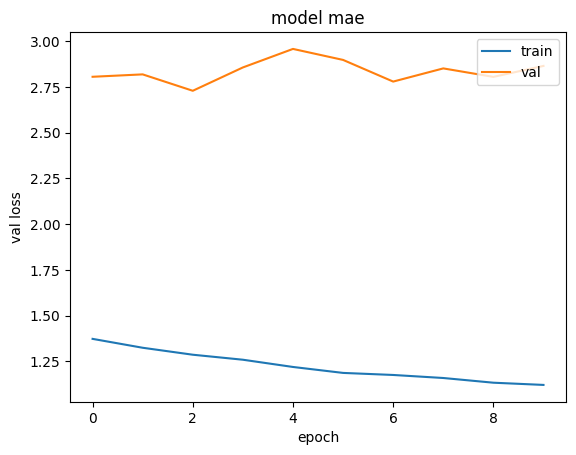

In [87]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model mae')
plt.ylabel('val loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [88]:
min(model.history.history['val_loss'])

2.729092836380005

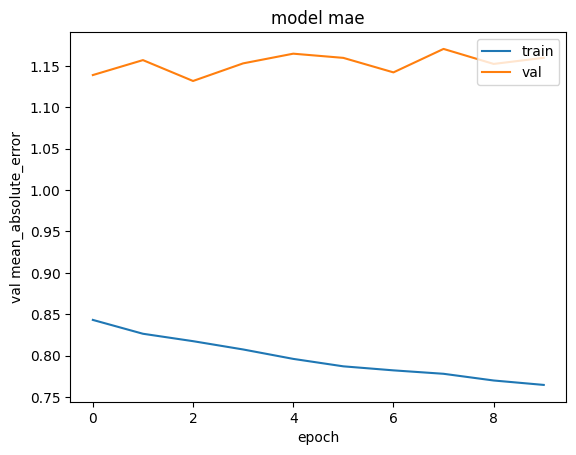

In [86]:
plt.plot(model.history.history['mean_absolute_error'])
plt.plot(model.history.history['val_mean_absolute_error'])
plt.title('model mae')
plt.ylabel('val mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [89]:
min(model.history.history['val_mean_absolute_error'])

1.1317012310028076

## prepare to try another model

In [55]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta = 1e-6, verbose = 1, patience=5)

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(None, max_features)))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='linear'))

opt = Adam(learning_rate=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

model.compile(loss = "mean_squared_error", optimizer=opt, metrics=['accuracy'])

In [ ]:
results = model.fit(text_ds, ds_score, validation_split = 0.2, epochs=1, batch_size=256, callbacks=[callback])